In [1]:
## Lydia Lee

%matplotlib inline
import numpy as np
from scipy import signal

from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
c = 3e10 # cm/s, speed of light
kB = 1.4e-16 # cgs, Boltzmann constant
# mp = 1e-24 # g, proton mass
m = 7.33500e-23 # g, mass of CO2 molecule
A21 = 10 # s^-1, Einstein A of the transition
L21 = 15e-4 # cm, wavelength of the transition
F21 = c / L21 # Hz, frequency of the transition

def lorentz(nu, A=A21, nu0=F21):
    """Return a Lorentzian line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        A: Einstein A coefficient [s^-1]
        nu0: center frequency [Hz]"""
    ans = A/(4*np.pi)**2 / ((nu - nu0)**2 + (A/(4*np.pi))**2)
    return ans / ans.sum()

def doppler(nu, T, m, nu0=F21):
    """Return a Gaussian line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        T: Temperature [K]
        m: Mass of the particle [g]
        nu0: center frequency [Hz]"""
    dnu = np.sqrt(2 * kB * T / m) * nu0/c
    ans = 1./(dnu * np.sqrt(np.pi)) * np.exp(-(nu-nu0)**2/dnu**2)
    return ans / sum(ans)

def voigt(nu, T, m, A=A21, nu0=F21):
    """Return a Voigt line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        T: Temperature [K]
        m: Mass of the particle [g]
        A: Einstein A coefficient [s^-1]
        nu0: center frequency [Hz]"""
    phi_lorentz = lorentz(nu=nu, A=A, nu0=nu0)
    phi_doppler = doppler(nu=nu, m=m, T=T, nu0=nu0)
    phi_voigt = np.convolve(phi_lorentz, phi_doppler, mode='same')
    phi_voigt_norm = phi_voigt/sum(phi_voigt)
    return phi_voigt_norm

def sigma(nu, A, T, m, nu0=F21):
    """Return the cross-section for photon absorption."""
    lamb0 = c/nu0
    return lamb0**2/(8*np.pi) * A * voigt(nu=nu, T=T, m=m, A=A, nu0=nu0)

<h2>1.1</h2>

In [3]:
# nu_vec_narrow = np.linspace(0.9995 * F21, 1.0005 * F21, 10000)
nu_vec_narrow = np.arange(0.99*F21, 1.01 * F21, F21*1e-7)
# nu_vec_narrow = np.arange(.9*F21, 1.1*F21, F21*1e-7)
T = 255 # K

In [4]:
prof_lorentz = lorentz(nu=nu_vec_narrow, A=A21, nu0=F21)
prof_doppler = doppler(nu=nu_vec_narrow, m=m, T=T, nu0=F21)
prof_voigt = voigt(nu=nu_vec_narrow, T=T, m=m, A=A21, nu0=F21)

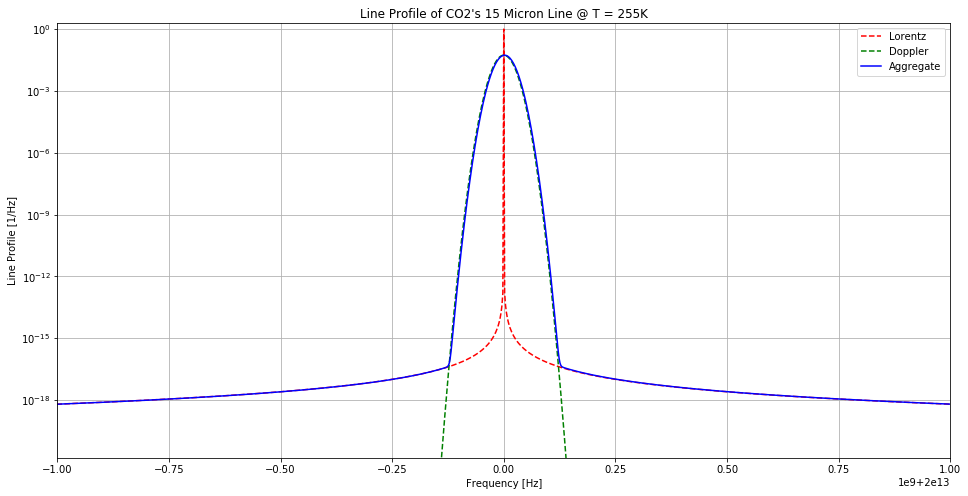

In [5]:
plt.rcParams['figure.figsize'] = (16, 8)

plt.semilogy(nu_vec_narrow, prof_lorentz, 'r--', label='Lorentz')
plt.semilogy(nu_vec_narrow, prof_doppler, 'g--',  label='Doppler')
plt.semilogy(nu_vec_narrow, prof_voigt, 'b', label='Aggregate')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Line Profile [1/Hz]')
plt.title(f'Line Profile of CO2\'s 15 Micron Line @ T = {T}K')
plt.ylim((prof_voigt[int(round(len(prof_voigt)*.45))], 2*max(max(prof_lorentz), max(prof_doppler), max(prof_voigt))))
plt.xlim((.99995*F21, 1.00005*F21))

plt.grid(True)
plt.legend()

<h2>1.2</h2>

In [6]:
hbar = 1e-27 # erg.s
h = hbar*2*np.pi # erg/Hz
tau0 = 3 # optical depth at line center
dnu = nu_vec_narrow[1]-nu_vec_narrow[0]

def planck_fun(nu_vec, T):
    '''
    Inputs:
        nu_vec: Numpy vector of floats. Frequencies in Hz.
        T: Float. Temperature in K.
    Outputs:
    '''
    return 2*h*nu_vec**3/c**2 * 1/(np.exp(h*nu_vec/(kB*T)) - 1)

In [7]:
# nu_vec_broad = np.arange(min(nu_vec_narrow)-.1*F21, max(nu_vec_narrow)+.1*F21, dnu/2)
nu_vec_broad = np.arange(F21/10, F21*10, F21/50000)

nu_min = min(nu_vec_narrow)
nu_max = max(nu_vec_narrow)
nu_overlap = [float(nu) for nu in nu_vec_broad if (nu < nu_max) and (nu > nu_min)]

# Combining non-uniform steps into a single axis and removing the screwy overlap
idx_overlap_broad = [i for i,nu in enumerate(nu_vec_broad) if float(nu) in nu_overlap]
nu_vec_broad_clipped = np.array([nu_vec_broad[i] for i,_ in enumerate(nu_vec_broad) if i not in idx_overlap_broad])
nu_vec_unsorted = np.concatenate([nu_vec_broad_clipped, nu_vec_narrow])
idx_sort = np.argsort(nu_vec_unsorted)
nu_vec = np.array([nu_vec_unsorted[i] for i in idx_sort])

In [8]:
# Incorporating 15um line absorption
## x-section (as a function of frequency), separated because of convolution
sigma_vec_broad = sigma(nu_vec_broad, A=A21, m=m, T=T, nu0=F21)
sigma_vec_narrow = sigma(nu_vec_narrow, A=A21, m=m, T=T, nu0=F21)
sigma_vec_broad_clipped = np.array([sigma_vec_broad[i] for i,_ in enumerate(sigma_vec_broad) if i not in idx_overlap_broad])
sigma_vec_unsorted = np.concatenate([sigma_vec_broad_clipped, sigma_vec_narrow])
sigma_vec = np.array([sigma_vec_unsorted[i] for i in idx_sort])

## getting column density of CO2 given tau=3 @ line center
idx = np.argwhere(np.diff(np.sign(nu_vec-F21))).flatten()[0] # idx of nearest nu to nu0
N = tau0/sigma_vec[idx]

## getting optical depth across different frequencies
tau_vec = N * sigma_vec
tau_vec_narrow = N * sigma_vec_narrow

In [9]:
# Blackbody radiation
B_blackbody = planck_fun(nu_vec=nu_vec, T=T)
B_blackbody_narrow = planck_fun(nu_vec=nu_vec_narrow, T=T)
B_wabs = np.multiply(B_blackbody, np.exp(-tau_vec))
B_wabs_narrow = np.multiply(B_blackbody_narrow, np.exp(-tau_vec_narrow))
B_diff = B_blackbody - B_wabs
B_diff_narrow = B_blackbody_narrow - B_wabs_narrow

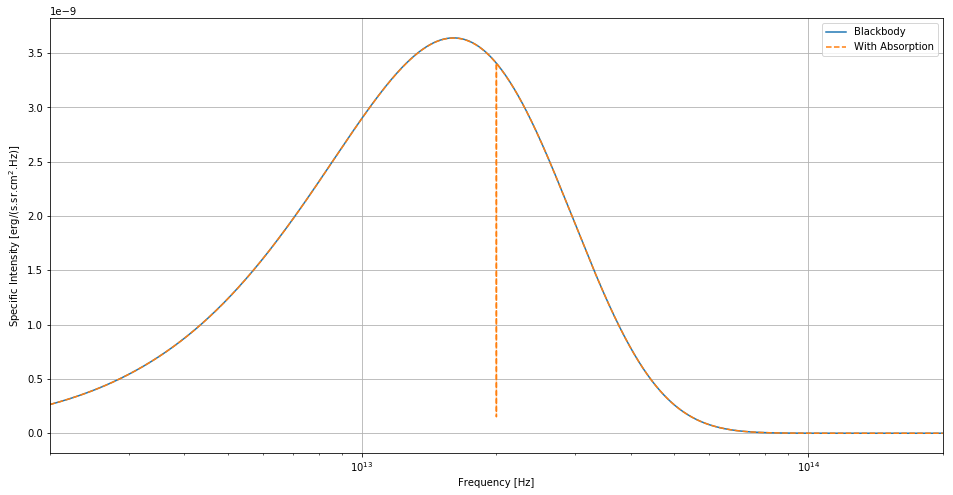

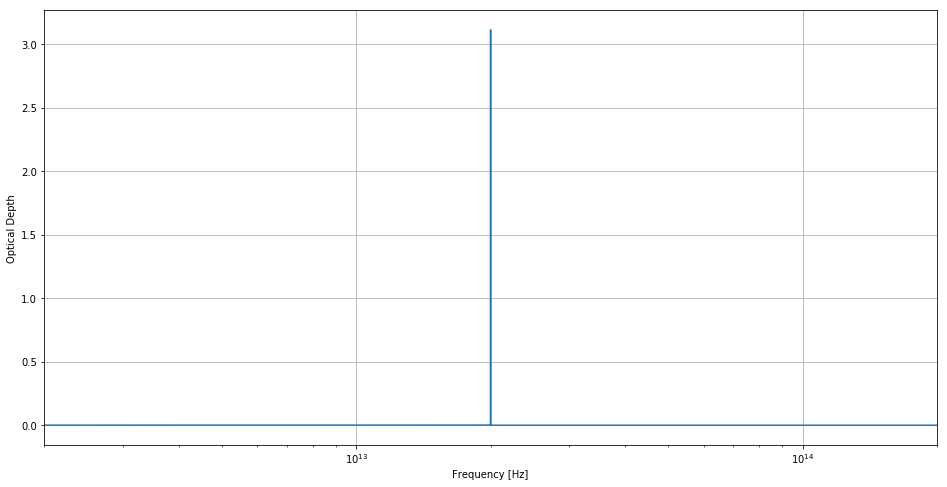

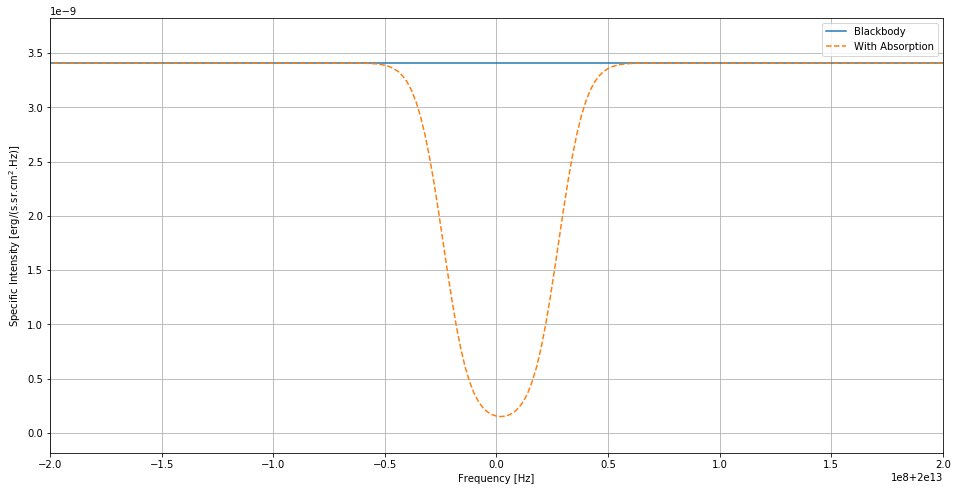

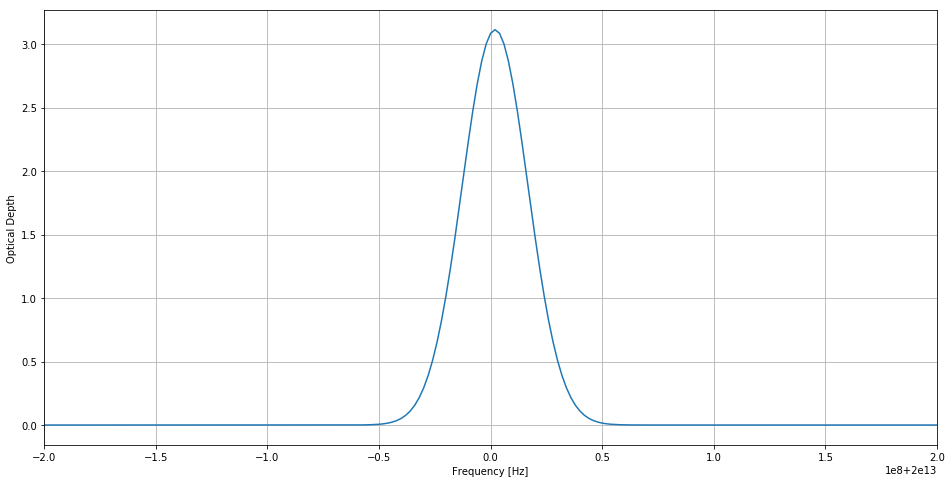

In [10]:
## Plotting over the full frequency range & a narrower range for visibility
for full_range in (True, False):
    xmin = min(nu_vec) if full_range else F21*.99999
    xmax = max(nu_vec) if full_range else F21 * 1.00001
    
    plt.figure()
    f = plt.semilogx if full_range else plt.plot
    f(nu_vec, B_blackbody, label='Blackbody')
    f(nu_vec, B_wabs, '--', label='With Absorption')
#     f(nu_vec, B_blackbody-B_wabs, '--', label='Absorbed')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Specific Intensity [erg/(s.sr.cm$^2$.Hz)]')
    plt.legend()
    plt.grid(True)
    plt.xlim((xmin, xmax))

    plt.figure()
    f(nu_vec, tau_vec)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Optical Depth')
    plt.xlim((xmin, xmax))
    plt.grid(True)
    
# plt.figure()
# plt.loglog(nu_vec, B_diff)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Absorbed Specific Intensity [erg/(s.sr.cm$^2$.Hz)]')
# plt.xlim((xmin*.9, xmax*1.1))

<h2>1.3</h2>

In [11]:
full_range = False # gets rid of screwy edge condition
B_diff_used = B_diff if full_range else B_diff_narrow
nu_vec_used = nu_vec if full_range else nu_vec_narrow
tau_vec_used = tau_vec if full_range else tau_vec_narrow

# Trapezoidal integration for total absorption by CO2
F_diff = np.trapz(B_diff_used, nu_vec_used) * 4*np.pi

# Absorption in optically thick region by CO2
idx_thick = [i for i, tau in enumerate(tau_vec_used) if tau > 1]
nu_vec_thick = [nu_vec_used[i] for i in idx_thick]
B_diff_thick = [B_diff_used[i] for i in idx_thick]
F_diff_thick = 4*np.pi * np.trapz(B_diff_thick, nu_vec_thick)

print(f'Blackbody:\t\t\t{4*np.pi*np.trapz(B_blackbody, nu_vec)} erg/(s.cm^2)')
print(f'With Absorption:\t\t{4*np.pi*np.trapz(B_wabs, nu_vec)} erg/(s.cm^2)')
print(f'Total Absorption:\t\t{F_diff} erg/(s.cm^2)')
print(f'->  Optically Thick:\t\t{F_diff_thick} erg/(s.cm^2)')
print(f'Optically Thick Fraction:\t{F_diff_thick/F_diff}')

Blackbody:			1185190.269734627 erg/(s.cm^2)
With Absorption:		1184789.1167810613 erg/(s.cm^2)
Total Absorption:		2.148553912785092 erg/(s.cm^2)
->  Optically Thick:		1.635072022366422 erg/(s.cm^2)
Optically Thick Fraction:	0.7610104697102702


<h2>1.4</h2>

In [12]:
sigma_blackbody = 2 * np.pi**5 * kB**4 / (15 * c**2 * h**3) # blackbody constant = Fblackbody/T^4

F_Earth_woabs = sigma_blackbody * T**4
F_Earth_compensate = (F_Earth_woabs + F_diff)
T_new = (F_Earth_compensate / sigma_blackbody)**.25
print(f'OG Temperature:\t\t{T} K')
print(f'New Temperature:\t{T_new} K')
print(f'Temp. Difference:\t{T_new - T} K')

OG Temperature:		255 K
New Temperature:	255.00046136688152 K
Temp. Difference:	0.0004613668815238725 K


In [13]:
# voigt_scratch = voigt(nu=nu_vec, T=T, m=m, A=A21, nu0=F21)
# sigma_scratch = sigma(nu=nu_vec, A=A21, T=T, m=m, nu0=F21)
# plt.semilogy(nu_vec, sigma_scratch, 'b', label='$\sigma$')
# plt.semilogy(nu_vec, voigt_scratch, 'r', label='Voigt')
# plt.xlim((min(nu_vec_fine), max(nu_vec_fine)))
# plt.legend()